# Лабараторная работа 5

### Андреев А.В. ИУ5-25М

Задание:
На основе рассмотренного на лекции примера реализуйте следующие алгоритмы:
- SARSA
- Q-обучение
- Двойное Q-обучение

для любой среды обучения с подкреплением (кроме рассмотренной на лекции среды Toy Text / Frozen Lake) из библиотеки Gym (или аналогичной библиотеки).

In [2]:
! pip install gymnasium
import numpy as np
import matplotlib.pyplot as plt
import gymnasium as gym
from tqdm import tqdm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 925.5/925.5 kB 13.6 MB/s eta 0:00:00


In [9]:
!pip install pygame 

import os
os.environ['SDL_VIDEODRIVER']='dummy'
import pygame
pygame.display.set_mode((640,480))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


<Surface(640x480x32 SW)>

In [3]:
class BasicAgent:
    '''
    Базовый агент, от которого наследуются стратегии обучения
    '''

    # Наименование алгоритма
    ALGO_NAME = '---'

    def __init__(self, env, eps=0.1):
        # Среда
        self.env = env
        # Размерности Q-матрицы
        self.nA = env.action_space.n
        self.nS = env.observation_space.n
        #и сама матрица
        self.Q = np.zeros((self.nS, self.nA))
        # Значения коэффициентов
        # Порог выбора случайного действия
        self.eps=eps
        # Награды по эпизодам
        self.episodes_reward = []

    def print_q(self):
        print('Вывод Q-матрицы для алгоритма ', self.ALGO_NAME)
        print(self.Q)

    def get_state(self, state):
        '''
        Возвращает правильное начальное состояние
        '''
        if type(state) is tuple:
            # Если состояние вернулось с виде кортежа, то вернуть только номер состояния
            return state[0]
        else:
            return state

    def greedy(self, state):
        '''
        <<Жадное>> текущее действие
        Возвращает действие, соответствующее максимальному Q-значению
        для состояния state
        '''
        return np.argmax(self.Q[state])

    def make_action(self, state):
        '''
        Выбор действия агентом
        '''
        if np.random.uniform(0,1) < self.eps:

            # Если вероятность меньше eps
            # то выбирается случайное действие
            return self.env.action_space.sample()
        else:
            # иначе действие, соответствующее максимальному Q-значению
            return self.greedy(state)

    def draw_episodes_reward(self):
        # Построение графика наград по эпизодам
        fig, ax = plt.subplots(figsize = (15,10))
        y = self.episodes_reward
        x = list(range(1, len(y)+1))
        plt.plot(x, y, '-', linewidth=1, color='green')
        plt.title('Награды по эпизодам')
        plt.xlabel('Номер эпизода')
        plt.ylabel('Награда')
        plt.show()

    def learn():
        '''
        Реализация алгоритма обучения
        '''
        pass


In [4]:
class SARSA_Agent(BasicAgent):
    '''
    Реализация алгоритма SARSA
    '''
    # Наименование алгоритма
    ALGO_NAME = 'SARSA'

    def __init__(self, env, eps=0.4, lr=0.1, gamma=0.98, num_episodes=20000):
        # Вызов конструктора верхнего уровня
        super().__init__(env, eps)
        # Learning rate
        self.lr=lr
        # Коэффициент дисконтирования
        self.gamma = gamma
        # Количество эпизодов
        self.num_episodes=num_episodes
        # Постепенное уменьшение eps
        self.eps_decay=0.00005
        self.eps_threshold=0.01

    def learn(self):
        '''
        Обучение на основе алгоритма SARSA
        '''
        self.episodes_reward = []
        # Цикл по эпизодам
        for ep in tqdm(list(range(self.num_episodes))):
            # Начальное состояние среды
            state = self.get_state(self.env.reset())
            # Флаг штатного завершения эпизода
            done = False
            # Флаг нештатного завершения эпизода
            truncated = False
            # Суммарная награда по эпизоду
            tot_rew = 0

            # По мере заполнения Q-матрицы уменьшаем вероятность случайного выбора действия
            if self.eps > self.eps_threshold:
                self.eps -= self.eps_decay

            # Выбор действия
            action = self.make_action(state)

            # Проигрывание одного эпизода до финального состояния
            while not (done or truncated):
                # Выполняем шаг в среде
                next_state, rew, done, truncated, _ = self.env.step(action)

                # Выполняем следующее действие
                next_action = self.make_action(next_state)

                # Правило обновления Q для SARSA
                self.Q[state][action] = self.Q[state][action] + self.lr * \
                    (rew + self.gamma * self.Q[next_state][next_action] - self.Q[state][action])

                # Следующее состояние считаем текущим
                state = next_state
                action = next_action
                # Суммарная награда за эпизод
                tot_rew += rew
                if (done or truncated):
                    self.episodes_reward.append(tot_rew)


In [5]:
class QLearning_Agent(BasicAgent):
    '''
    Реализация алгоритма Q-Learning
    '''
    # Наименование алгоритма
    ALGO_NAME = 'Q-обучение'

    def __init__(self, env, eps=0.4, lr=0.1, gamma=0.98, num_episodes=20000):
        # Вызов конструктора верхнего уровня
        super().__init__(env, eps)
        # Learning rate
        self.lr=lr
        # Коэффициент дисконтирования
        self.gamma = gamma
        # Количество эпизодов
        self.num_episodes=num_episodes
        # Постепенное уменьшение eps
        self.eps_decay=0.00005
        self.eps_threshold=0.01

    def learn(self):
        '''
        Обучение на основе алгоритма Q-Learning
        '''
        self.episodes_reward = []
        # Цикл по эпизодам
        for ep in tqdm(list(range(self.num_episodes))):
            # Начальное состояние среды
            state = self.get_state(self.env.reset())
            # Флаг штатного завершения эпизода
            done = False
            # Флаг нештатного завершения эпизода
            truncated = False
            # Суммарная награда по эпизоду
            tot_rew = 0

            # По мере заполнения Q-матрицы уменьшаем вероятность случайного выбора действия
            if self.eps > self.eps_threshold:
                self.eps -= self.eps_decay

            # Проигрывание одного эпизода до финального состояния
            while not (done or truncated):
                # Выбор действия
                # В SARSA следующее действие выбиралось после шага в среде
                action = self.make_action(state)

                # Выполняем шаг в среде
                next_state, rew, done, truncated, _ = self.env.step(action)

                # Правило обновления Q для SARSA (для сравнения)
                # self.Q[state][action] = self.Q[state][action] + self.lr * \
                #     (rew + self.gamma * self.Q[next_state][next_action] - self.Q[state][action])

                # Правило обновления для Q-обучения
                self.Q[state][action] = self.Q[state][action] + self.lr * \
                    (rew + self.gamma * np.max(self.Q[next_state]) - self.Q[state][action])

                # Следующее состояние считаем текущим
                state = next_state
                # Суммарная награда за эпизод
                tot_rew += rew
                if (done or truncated):
                    self.episodes_reward.append(tot_rew)


In [6]:
class DoubleQLearning_Agent(BasicAgent):
    '''
    Реализация алгоритма Double Q-Learning
    '''
    # Наименование алгоритма
    ALGO_NAME = 'Двойное Q-обучение'

    def __init__(self, env, eps=0.4, lr=0.1, gamma=0.98, num_episodes=20000):
        # Вызов конструктора верхнего уровня
        super().__init__(env, eps)
        # Вторая матрица
        self.Q2 = np.zeros((self.nS, self.nA))
        # Learning rate
        self.lr=lr
        # Коэффициент дисконтирования
        self.gamma = gamma
        # Количество эпизодов
        self.num_episodes=num_episodes
        # Постепенное уменьшение eps
        self.eps_decay=0.00005
        self.eps_threshold=0.01


    def greedy(self, state):
        '''
        <<Жадное>> текущее действие
        Возвращает действие, соответствующее максимальному Q-значению
        для состояния state
        '''
        temp_q = self.Q[state] + self.Q2[state]
        return np.argmax(temp_q)

    def print_q(self):
        print(f"Вывод Q-матриц для алгоритма {self.ALGO_NAME}")
        print('Q1')
        print(self.Q)
        print('Q2')
        print(self.Q2)

    def learn(self):
        '''
        Обучение на основе алгоритма Double Q-Learning
        '''
        self.episodes_reward = []
        # Цикл по эпизодам
        for ep in tqdm(list(range(self.num_episodes))):
            # Начальное состояние среды
            state = self.get_state(self.env.reset())
            # Флаг штатного завершения эпизода
            done = False
            # Флаг нештатного завершения эпизода
            truncated = False
            # Суммарная награда по эпизоду
            tot_rew = 0

            # По мере заполнения Q-матрицы уменьшаем вероятность случайного выбора действия
            if self.eps > self.eps_threshold:
                self.eps -= self.eps_decay

            # Проигрывание одного эпизода до финального состояния
            while not (done or truncated):
                # Выбор действия
                # В SARSA следующее действие выбиралось после шага в среде
                action = self.make_action(state)

                # Выполняем шаг в среде
                next_state, rew, done, truncated, _ = self.env.step(action)

                if np.random.rand() < 0.5:
                    # Обновление первой таблицы
                    self.Q[state][action] = self.Q[state][action] + self.lr * \
                        (rew + self.gamma * self.Q2[next_state][np.argmax(self.Q[next_state])] - self.Q[state][action])
                else:
                    # Обновление второй таблицы
                    self.Q2[state][action] = self.Q2[state][action] + self.lr * \
                        (rew + self.gamma * self.Q[next_state][np.argmax(self.Q2[next_state])] - self.Q2[state][action])

                # Следующее состояние считаем текущим
                state = next_state
                # Суммарная награда за эпизод
                tot_rew += rew
                if (done or truncated):
                    self.episodes_reward.append(tot_rew)


In [7]:
def play_agent(agent):
    '''
    Проигрывание сессии для обученного агента
    '''
    env2 = gym.make('Taxi-v3', render_mode='human')
    state = env2.reset()[0]
    done = False
    while not done:
        action = agent.greedy(state)
        next_state, reward, terminated, truncated, _ = env2.step(action)
        env2.render()
        state = next_state
        if terminated or truncated:
            done = True

def run_sarsa():
    env = gym.make('Taxi-v3')
    agent = SARSA_Agent(env)
    agent.learn()
    agent.print_q()
    agent.draw_episodes_reward()
    play_agent(agent)

def run_q_learning():
    env = gym.make('Taxi-v3')
    agent = QLearning_Agent(env)
    agent.learn()
    agent.print_q()
    agent.draw_episodes_reward()
    play_agent(agent)
    
def run_double_q_learning():
    env = gym.make('Taxi-v3')
    agent = DoubleQLearning_Agent(env)
    agent.learn()
    agent.print_q()
    agent.draw_episodes_reward()
    play_agent(agent)

#Q-обучение: eps=0.4, lr=0.1, gamma=0.98, num_episodes=20000

100%|██████████| 20000/20000 [00:28<00:00, 694.21it/s] 


Вывод Q-матрицы для алгоритма  Q-обучение
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 5.58599340e+00  5.28914709e+00  2.65485462e+00  6.25853489e+00
   8.36234335e+00 -3.22342530e+00]
 [ 1.02090120e+01  1.14844077e+01  9.54867289e+00  1.12279210e+01
   1.32744558e+01  2.72950442e+00]
 ...
 [ 7.23145413e-01  1.44979861e+01  2.18515897e+00  3.37640859e+00
  -2.19392489e+00 -2.28245138e-01]
 [-2.28561394e+00 -3.05448930e+00 -2.07576329e+00  8.64976904e+00
  -7.36093582e+00 -5.68044930e+00]
 [ 4.33742165e+00  8.01209901e+00  7.83197358e+00  1.85995560e+01
   6.49927364e-01 -1.79063409e-02]]


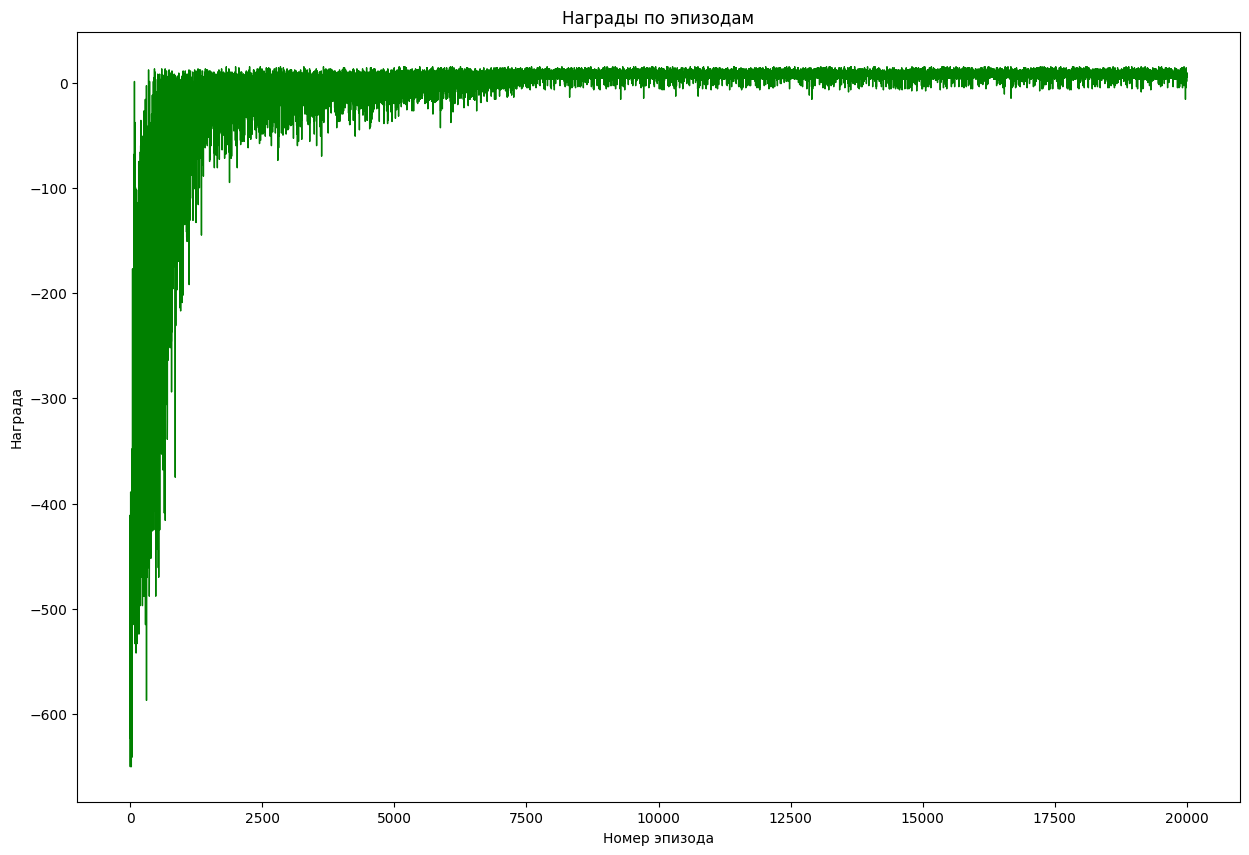

In [10]:
run_q_learning()

#SARSA: eps=0.4, lr=0.1, gamma=0.98, num_episodes=20000

100%|██████████| 20000/20000 [00:18<00:00, 1053.15it/s]


Вывод Q-матрицы для алгоритма  SARSA
[[  0.           0.           0.           0.           0.
    0.        ]
 [ -8.13722541  -4.05700541  -7.0877638   -3.87798332   7.5400152
  -13.2738793 ]
 [  3.61870409   1.03341828   2.01914443   2.72687414  12.98269841
   -3.65347348]
 ...
 [ -1.96645351   4.34519884  -2.8042698   -2.30629889  -7.63590646
   -7.07396573]
 [ -8.27469315  -4.69794469  -8.20679618  -8.36130488 -11.2141191
  -14.39931933]
 [  5.20526424   2.65878702   3.01696359  18.32079897  -1.08148793
    1.28192931]]


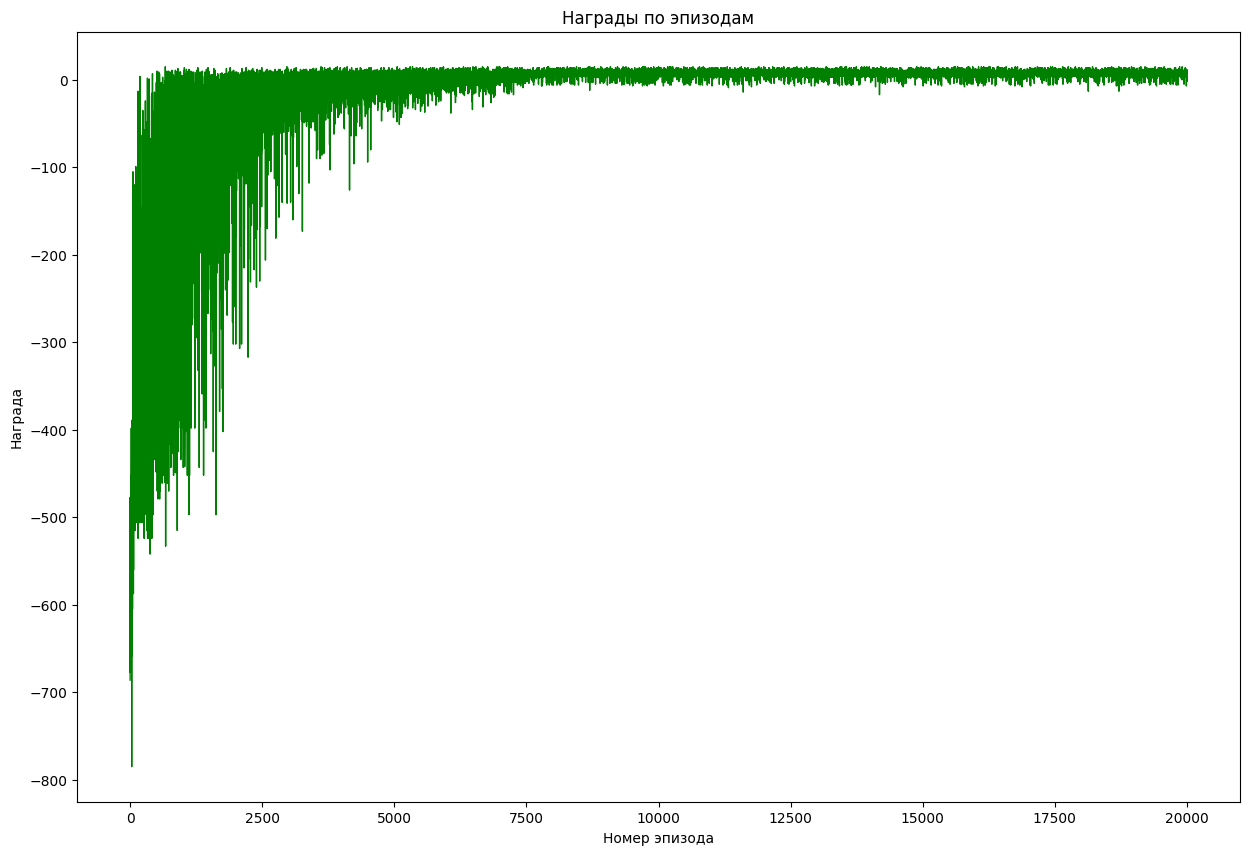

In [11]:
run_sarsa()

# Двойное Q-обучение: eps=0.4, lr=0.1, gamma=0.98, num_episodes=20000

100%|██████████| 20000/20000 [00:22<00:00, 907.80it/s] 


Вывод Q-матриц для алгоритма Двойное Q-обучение
Q1
[[ 0.          0.          0.          0.          0.          0.        ]
 [ 0.1202919   2.59398205  1.34661889  2.73597525  8.36234335 -6.61585321]
 [ 5.44874032  6.91348991  6.95366939  7.64601045 13.27445578  0.97720877]
 ...
 [-2.12788739 12.727057   -0.80514474 -1.86945785 -2.27894974 -2.35422641]
 [-4.47724985 -4.72767349 -4.29663036  4.8685616  -8.18200098 -6.29420531]
 [ 0.          1.02175373  0.4446035  17.95716899  0.54578177 -0.22423952]]
Q2
[[ 0.          0.          0.          0.          0.          0.        ]
 [-0.77561489  4.32896317  1.50810902  4.16410949  8.36234335 -4.36975284]
 [ 5.35893609  7.43860351  4.52425191  3.27660336 13.27445578  1.26094111]
 ...
 [ 0.32403326 13.99759692 -1.47306238 -0.12026345 -4.36611298 -2.64755413]
 [-4.04293376 -3.89086803 -3.76972697  3.93192412 -6.5740198  -8.01947602]
 [ 1.25504971  0.          1.65980256 18.12858333 -1.15992294 -1.07276613]]


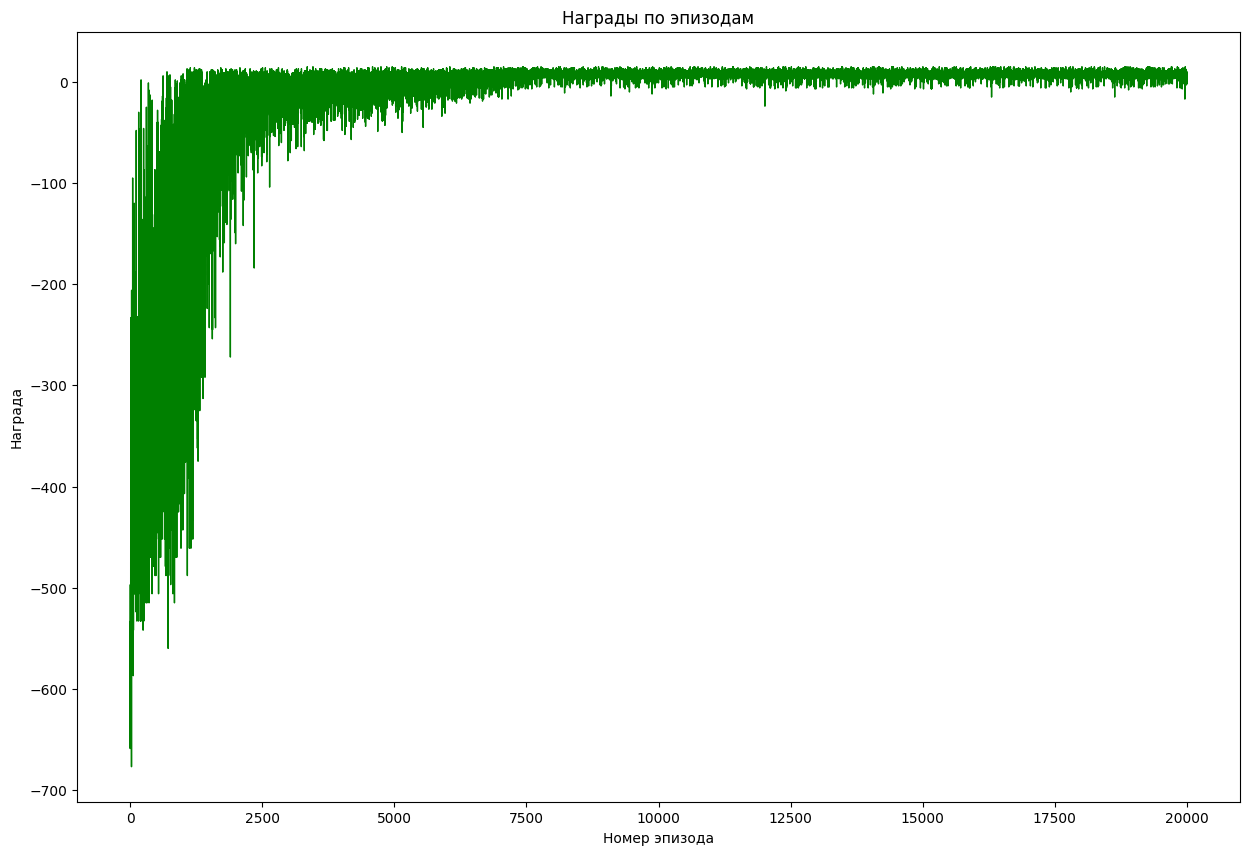

In [12]:
run_double_q_learning()

# Вывод
На параметрах по умолчанию быстрее всего сходится Q-обучение. Gamma
подобрана удачно, крупные изменения значения делают результат хуже.